In [9]:
import jax.numpy as jnp
import project_2 as p2
import seaborn as sns
from tqdm import tqdm
import imp
imp.reload(p2)
sns.set(context='talk',style='darkgrid')

# Problem setup:

## States:

$$
x(t) = \left[ 
        \Re\{\bar{V}_1(t)\},
        \Im\{\bar{V}_1(t)\},
        c_g(t),
        s_g(t),
        \delta_g(t),
        \omega_g(t),
        \Re\{\bar{V}_2(t)\},
        \Im\{\bar{V}_2(t)\},
        c_m(t),
        s_m(t),
        \delta_m(t),
        \omega_m(t)
    \right]^T
$$

## System Parameters and Initial Conditions:

In [10]:
#Initial conditions
Ig = 0.75 * jnp.exp(jnp.deg2rad(180)*1j)
Eg = 1.0315 * jnp.exp(jnp.deg2rad(14.2)*1j)
Im = 0.75 #* np.exp(0*1j)
Em = 1/(p2.bm*-1j)*(-1*Im) +1
Pgm = 0.75
Pmm = 0.75
V1 = 1/(p2.b*-1j)*Im + 1
V2 = 1.0*jnp.exp(0*1j)

#Parameters that were not stated anywhere in the project.
omega0 = 2*jnp.pi*60


## Measurements 

In [11]:
measurements  = jnp.array([[1.000, 0.100, 1.000, 0.000, 0.750, 0.000, -0.750, 0.000,-0.750, 0.000, 0.750, 0.000, 0.000, 0.000],
                          [1.000, 0.100, 1.000, 0.000, 0.750, 0.000, -0.750, 0.000, -0.750, 0.000, 0.750, 0.000, 0.000, 0.000,],
                          [0.993, 0.030, 0.987, -0.114, 1.079, -0.041, -1.079, 0.041, -1.079, 0.041, 0.141, 0.068, -0.392, -1.092],
                          [0.991, 0.013, 0.983, -0.135, 1.111, -0.060, -1.111, 0.060, -1.111, 0.060, 0.177, 0.068, -0.811, -2.146],
                          [0.988, -0.014, 0.975, -0.169, 1.160, -0.095, -1.160, 0.095,-1.160, 0.095, 0.233, 0.065, -1.278, -3.125],
                          [0.982, -0.052, 0.963, -0.215, 1.219, -0.148, -1.219, 0.148,-1.219, 0.148, 0.305, 0.056, -1.813, -4.001],
                          [0.974, -0.101, 0.944, -0.271, 1.281, -0.222, -1.281, 0.222, -1.281, 0.222, 0.384, 0.036, -2.425, -4.757],
                          [0.960, -0.159, 0.918, -0.337, 1.335, -0.318, -1.335, 0.318, -1.335, 0.318, 0.464, 0.002, -3.118, -5.387],
                          [0.941, -0.226, 0.883, -0.409, 1.372, -0.436, -1.372, 0.436, -1.372, 0.436, 0.534, -0.047, -3.888, -5.896],
                          [0.915, -0.302, 0.838, -0.487, 1.382, -0.572, -1.382, 0.572, -1.382, 0.572, 0.586, -0.110, -4.723, -6.300],
                          [0.916, -0.334, 0.844, -0.482, 1.106, -0.538, -1.106, 0.538, -1.106, 0.538, 1.106, -0.538, -5.609, -6.622],
                          [0.877, -0.424, 0.790, -0.565, 1.055, -0.652, -1.055, 0.652, -1.055, 0.652, 1.055, -0.652, -6.175, -5.836],
                          [0.832, -0.512, 0.734, -0.640, 0.959, -0.735, -0.959, 0.735, -0.959, 0.735, 0.959, -0.735, -6.730, -5.067],
                          [0.780, -0.597, 0.676, -0.707, 0.828, -0.778, -0.828, 0.778, -0.828, 0.778, 0.828, -0.778, -7.226, -4.377]
                         ])

In [12]:
P = 10e6*jnp.eye(8)
W = (1/(0.01**2))*jnp.eye(measurements.shape[1])

## Dynamic State Estimation

In [13]:
x_k = jnp.array([jnp.real(V1),jnp.imag(V1),jnp.cos(jnp.angle(Eg)),jnp.sin(jnp.angle(Eg)),jnp.angle(Eg),0,jnp.real(V2),jnp.imag(V2),jnp.cos(jnp.angle(Em)),jnp.sin(jnp.angle(Em)),jnp.angle(Em),0])
print(x_k)

[ 1.          0.1         0.96944535  0.2453074   0.24783677  0.
  1.          0.          0.99174285 -0.12824261 -0.12859675  0.        ]


In [14]:
print(p2.g_cons(x_k,x_t_h))

[-2.0358711e-06  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -9.3132257e-10  0.0000000e+00  0.0000000e+00  0.0000000e+00]


In [15]:
jnp.abs(p2.Em)

DeviceArray(1.0083259, dtype=float32, weak_type=True)

In [16]:
X = []
tol = 1e-6
k = 0
x_t_h = x_k

In [17]:
g = p2.g_cons(x_k,x_t_h)
print(g)

[-2.0358711e-06  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -9.3132257e-10  0.0000000e+00  0.0000000e+00  0.0000000e+00]


In [18]:
x_k

DeviceArray([ 1.        ,  0.1       ,  0.96944535,  0.2453074 ,
              0.24783677,  0.        ,  1.        ,  0.        ,
              0.99174285, -0.12824261, -0.12859675,  0.        ],            dtype=float32)

In [20]:
def d_vec(x_k,x_t_h,z):
    h_x = p2.h(x_k)-z
    g_x_k = p2.g_cons(x_k,x_t_h)
    d = jnp.concatenate([h_x,g_x_k])
    return d

def update_rule(x_k,H,G,W,P,d):
    x_k_1 = x_k - jnp.linalg.inv(H.T@W@H + G.T@P@G)@(jnp.hstack([H.T@W,G.T@P]))@d
    return x_k_1


In [21]:

for z,t in enumerate(measurements):
    print("==============================t= ",t)
    #while np.linalg.norm(d[0:len(x)])
    for i in tqdm(range(10)):
        
        #print(x_k)
        H = p2.measurement_jacobian(x_k)
        G = p2.constraint_jacobian(x_k,x_t_h)
        #print(H,G)
        d = d_vec(x_k,x_t_h,z)
        x_k = update_rule(x_k,H,G,W,P,d)
       
        #print(d[14:])
    print(x_k)
    X.append(x_k)
    x_t_h = x_k

==============================t=  [ 1.    0.1   1.    0.    0.75  0.   -0.75  0.   -0.75  0.    0.75  0.
  0.    0.  ]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.02it/s]


[ 0.9646964   0.05404159  0.96868736  0.2401096   0.24745087 -0.04630755
  0.9659694   0.01294854  0.9906636  -0.12329923 -0.1282995   0.03566969]
==============================t=  [ 1.    0.1   1.    0.    0.75  0.   -0.75  0.   -0.75  0.    0.75  0.
  0.    0.  ]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.07it/s]


[ 0.81678665  0.2811698   0.96754473  0.24256282  0.25458863  0.90283746
  0.82044375  0.23619276  0.99149066 -0.10847383 -0.11926823  1.0480828 ]
==============================t=  [ 0.993  0.03   0.987 -0.114  1.079 -0.041 -1.079  0.041 -1.079  0.041
  0.141  0.068 -0.392 -1.092]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.16it/s]


[ 0.6714706   0.49843517  0.9629966   0.26277     0.27981427  2.1242385
  0.67691356  0.45090201  0.99437267 -0.07476535 -0.09209874  2.2122557 ]
==============================t=  [ 0.991  0.013  0.983 -0.135  1.111 -0.06  -1.111  0.06  -1.111  0.06
  0.177  0.068 -0.811 -2.146]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.06it/s]


[ 0.5259481   0.73241633  0.9528534   0.30259287  0.32565045  3.3761046
  0.5337131   0.68250775  0.99723357 -0.02102015 -0.04543794  3.3870401 ]
==============================t=  [ 0.988 -0.014  0.975 -0.169  1.16  -0.095 -1.16   0.095 -1.16   0.095
  0.233  0.065 -1.278 -3.125]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.07it/s]


[0.37866777 0.98403597 0.93421566 0.3612903  0.39242956 4.637389
 0.3892818  0.93156964 0.99660474 0.05267954 0.0209326  4.577424  ]
==============================t=  [ 0.982 -0.052  0.963 -0.215  1.219 -0.148 -1.219  0.148 -1.219  0.148
  0.305  0.056 -1.813 -4.001]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.07it/s]


[0.22736892 1.2531108  0.9030881  0.43719852 0.48028874 5.9057117
 0.24132423 1.1978703  0.98774844 0.14584489 0.10730483 5.787243  ]
==============================t=  [ 0.974 -0.101  0.944 -0.271  1.281 -0.222 -1.281  0.222 -1.281  0.222
  0.384  0.036 -2.425 -4.757]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.05it/s]


[0.06861918 1.5397125  0.8545743  0.52749234 0.5893086  7.1766706
 0.08642276 1.4815387  0.9647137  0.2570838  0.21399994 7.0161686 ]
==============================t=  [ 9.600e-01 -1.590e-01  9.180e-01 -3.370e-01  1.335e+00 -3.180e-01
 -1.335e+00  3.180e-01 -1.335e+00  3.180e-01  4.640e-01  2.000e-03
 -3.118e+00 -5.387e+00]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.06it/s]


[-0.10258295  1.8440355   0.7833296   0.62770694  0.7194467   8.439898
 -0.08036838  1.7829107   0.92057997  0.38347366  0.3412896   8.258589  ]
==============================t=  [ 0.941 -0.226  0.883 -0.409  1.372 -0.436 -1.372  0.436 -1.372  0.436
  0.534 -0.047 -3.888 -5.896]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.03it/s]


[-0.29327095  2.165707    0.684329    0.731286    0.87042165  9.6770935
 -0.2660305   2.1018784   0.8480254   0.5198709   0.4892919   9.501684  ]
==============================t=  [ 0.915 -0.302  0.838 -0.487  1.382 -0.572 -1.382  0.572 -1.382  0.572
  0.586 -0.11  -4.723 -6.3  ]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.09it/s]


[-0.51274806  2.5023677   0.5539993   0.8293615   1.0415704  10.860759
 -0.47990948  2.4364974   0.7403629   0.658295    0.65783095 10.723002  ]
==============================t=  [ 0.916 -0.334  0.844 -0.482  1.106 -0.538 -1.106  0.538 -1.106  0.538
  1.106 -0.538 -5.609 -6.622]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.13it/s]


[-0.77196157  2.8474362   0.39165485  0.91103214  1.2316964  11.954354
 -0.73322266  2.7807138   0.5931386   0.7876631   0.8462581  11.888253  ]
==============================t=  [ 0.877 -0.424  0.79  -0.565  1.055 -0.652 -1.055  0.652 -1.055  0.652
  1.055 -0.652 -6.175 -5.836]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.04it/s]


[-1.0811272   3.1875865   0.20096107  0.96441233  1.4389446  12.915425
 -1.0368066   3.1216729   0.40618962  0.8943011   1.0532533  12.951163  ]
==============================t=  [ 0.832 -0.512  0.734 -0.64   0.959 -0.735 -0.959  0.735 -0.959  0.735
  0.959 -0.735 -6.73  -5.067]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.15it/s]


[-1.4450641e+00  3.5014892e+00 -9.1170846e-03  9.7855872e-01
  1.6607674e+00  1.3703317e+01 -1.3964446e+00  3.4381614e+00
  1.8565263e-01  9.6367639e-01  1.2766678e+00  1.3858581e+01]
==============================t=  [ 0.78  -0.597  0.676 -0.707  0.828 -0.778 -0.828  0.778 -0.828  0.778
  0.828 -0.778 -7.226 -4.377]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.15it/s]

[-1.8571725   3.7621977  -0.22457145  0.94595915  1.8940582  14.29158
 -1.8065852   3.7026997  -0.05508753  0.9834302   1.5135198  14.563657  ]


In [22]:
d

DeviceArray([-1.4857172e+01, -9.2378025e+00, -1.4806585e+01,
             -9.2973003e+00, -1.2553764e+01, -1.2620595e+01,
             -1.3446236e+01, -1.3379405e+01,  6.5356064e-01,
             -5.0349174e+00,  2.7242737e+00, -2.8439732e+00,
              1.2915802e+00,  1.5636559e+00, -1.0230102e-01,
             -2.9802322e-08,  9.0051591e-03, -5.1648407e-03,
             -1.5500855e-01, -5.2154064e-08, -1.0132797e-02,
              4.5272643e-03], dtype=float32)

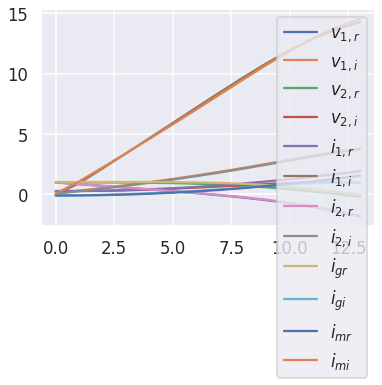

In [23]:
import matplotlib.pyplot as plt
X = jnp.asarray(X)
names = ['$v_{1,r}$','$v_{1,i}$','$v_{2,r}$','$v_{2,i}$','$i_{1,r}$','$i_{1,i}$','$i_{2,r}$','$i_{2,i}$','$i_{gr}$','$i_{gi}$','$i_{mr}$','$i_{mi}$','$\omega_g$','$\omega_m$']
for i in range(12):
    name = names[i]
    plt.plot(X[:,i],label=name)
plt.legend()

Text(0.5, 1.0, 'Voltage Mags and Angles. ')

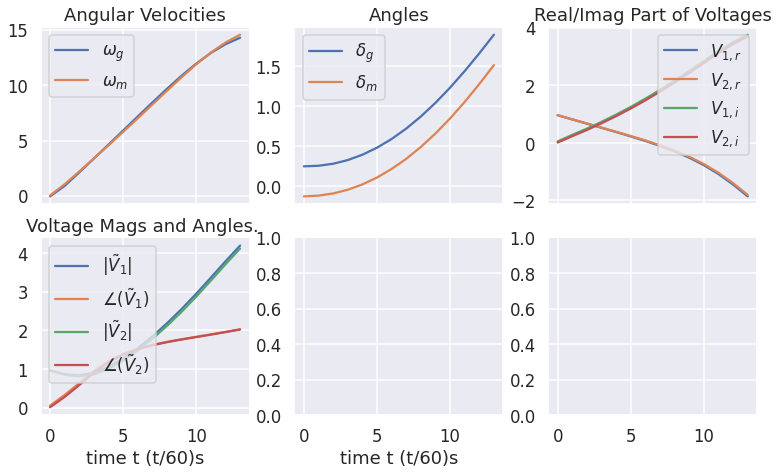

In [24]:
figscale = 3
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(figscale*3.5,figscale*3.5/1.61828),constrained_layout=True,sharex=True)
axes[1,0].set_xlabel("time t (t/60)s")
axes[1,1].set_xlabel("time t (t/60)s")

#Generator and motor speed
axes[0,0].plot([p2.omegag(x) for x in X],label="$\omega_g$")
axes[0,0].plot([p2.omegam(x) for x in X],label="$\omega_m$")
axes[0,0].legend()
axes[0,0].set_title("Angular Velocities")
#Deltas
axes[0,1].plot([p2.deltag(x) for x in X],label="$\delta_g$")
axes[0,1].plot([p2.deltam(x) for x in X],label="$\delta_m$")
axes[0,1].legend()
axes[0,1].set_title("Angles")
#Voltages
axes[0,2].plot([p2.v1r(x) for x in X],label="$V_{1,r}$")
axes[0,2].plot([p2.v2r(x) for x in X],label="$V_{2,r}$")
axes[0,2].plot([p2.v1i(x) for x in X],label="$V_{1,i}$")
axes[0,2].plot([p2.v2i(x) for x in X],label="$V_{2,i}$")
axes[0,2].legend()
axes[0,2].set_title("Real/Imag Part of Voltages")

#Currents
axes[1,0].plot([jnp.abs(p2.v1r(x) + p2.v1i(x)*1j) for x in X],label=r"$|\tilde{V}_1|$")
axes[1,0].plot([jnp.angle(p2.v1r(x) + p2.v1i(x)*1j) for x in X],label=r"$\angle(\tilde{V}_1)$")
axes[1,0].plot([jnp.abs(p2.v2r(x) + p2.v2i(x)*1j) for x in X],label=r"$|\tilde{V}_{2}|$")
axes[1,0].plot([jnp.angle(p2.v2r(x) + p2.v2i(x)*1j)for x in X],label=r"$\angle(\tilde{V}_{2})$")
axes[1,0].legend()
axes[1,0].set_title("Voltage Mags and Angles. ")


In [80]:
print(X[0])

[ 0.99652762  0.09944135  0.96483151  0.26284665  0.26603139  0.98236367
  0.99677504 -0.00453833  0.98927001 -0.14607636 -0.14665903 -0.91990502]
